# Evaluating the NY Taxi Data
The notebook lopoks at various features of the NY taxi dataset.  
Processing is done one a single GPU

In [1]:
# Let's first look at the available hardware - The amount og GPU memeory wil affect how much data we can process
!nvidia-smi

Thu Nov 14 22:24:44 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro GV100        Off  | 00000000:04:00.0  On |                  Off |
| 40%   53C    P2    43W / 250W |  17058MiB / 32470MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Quadro GV100        Off  | 00000000:84:00.0 Off |                  Off |
| 39%   52C    P2    61W / 250W |    317MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
# Load the required modules
import time

import cudf
import cuml
import cugraph

import xgboost as xgb


import numpy as np

## Read in the data

In [4]:
datafiles = [
    '../../data/yellow_tripdata_2016-01.csv',
    '../../data/yellow_tripdata_2016-02.csv',
    '../../data/yellow_tripdata_2016-03.csv'
#    '../../data/yellow_tripdata_2016-04.csv'
]

In [5]:
# Look at the first line of a data file, which is field header information
!head -n 1 '../../data/yellow_tripdata_2016-01.csv'

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount


In [6]:
# I don't really like those column names, let me define my own
# also, by specifying the data types we can reduce read times and memory 
col_names = [
    'vendor_id', 
    'pickup_datetime',
    'dropoff_datetime',
    'passenger_count', 
    'trip_distance',
    'pickup_longitude',
    'pickup_latitude',     
    'rate_code',
    'store_and_fwd_flag',
    'dropoff_longitude',
    'dropoff_latitude',    
    'payment_type',
    'fare_amount',
    'extra',
    'mta_tax',
    'tip_amount',
    'tolls_amount',
    'surcharge',
    'total_amount'
]

col_dtype = [
    'int32',
    'date',
    'date',
    'int32',
    'int32',
    'float64',
    'float64',
    'int32',
    'int32',    
    'float64',
    'float64',    
    'int32',    
    'float64',    
    'float64',    
    'float64',    
    'float64',    
    'float64',    
    'float64',    
    'float64'
]

# don't want to use all columns, specifiy just a few
use_col  = [
    'pickup_datetime',
    'dropoff_datetime',
    'passenger_count', 
    'trip_distance',
    'pickup_longitude',
    'pickup_latitude',     
    'rate_code',
    'dropoff_longitude',
    'dropoff_latitude',    
    'fare_amount',
    'extra',
    'tip_amount',
    'total_amount'
]

In [7]:
%%time
# Load the data
num_files = len(datafiles)

gdf_a = [None] * num_files

for i in range(num_files) :
    gdf_a[i] = cudf.read_csv(datafiles[i], names=col_names, dtype=col_dtype, delimiter=',', skiprows=1, usecols=use_col)
    
# merge the data sets together
taxi_df = cudf.concat(gdf_a)   

del gdf_a

CPU times: user 4.21 s, sys: 1.06 s, total: 5.27 s
Wall time: 5.3 s


In [8]:
# let's peek at the first few records
taxi_df.head(2)

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,extra,tip_amount,total_amount
0,2016-01-01,2016-01-01,2,1,-73.990372,40.734695,1,-73.981842,40.732407,7.5,0.5,0.0,8.8
1,2016-01-01,2016-01-01,5,4,-73.980782,40.729912,1,-73.944473,40.716679,18.0,0.5,0.0,19.3


## Remove bad data

In [9]:
# How much data was loaded?
len(taxi_df)

34499859

In [10]:
%%time

# filter out records with missing or outlier values
query_frags = ("(fare_amount > 0 and fare_amount < 500) " +
        "and (passenger_count > 0 and passenger_count < 6) " +
        "and (pickup_longitude > -75 and pickup_longitude < -73) " +
        "and (dropoff_longitude > -75 and dropoff_longitude < -73) " +
        "and (pickup_latitude > 40 and pickup_latitude < 42) " +
        "and (dropoff_latitude > 40 and dropoff_latitude < 42)"
    )

taxi_df = taxi_df.query(query_frags)

CPU times: user 203 ms, sys: 46.2 ms, total: 249 ms
Wall time: 283 ms


In [11]:
# How much data (records) were loaded?
len(taxi_df)

32755964

## Now add some additional fields 

In [12]:
# expand the datetime into individual fields
import datetime as dt

taxi_df['hour'] = taxi_df['pickup_datetime'].dt.hour
taxi_df['year'] = taxi_df['pickup_datetime'].dt.year
taxi_df['month'] = taxi_df['pickup_datetime'].dt.month
taxi_df['day'] = taxi_df['pickup_datetime'].dt.day
taxi_df['diff'] = taxi_df['dropoff_datetime'].astype('int32') - taxi_df['pickup_datetime'].astype('int32')

# drop the original datetime fields
taxi_df = taxi_df.drop(['pickup_datetime','dropoff_datetime'])
    

In [13]:
# create a 'day of week' field
import math

def day_of_the_week(day, month, year, day_of_week):
    for i, (d_1, m_1, y_1) in enumerate(zip(day, month, year)):
        if month[i] < 3:
            shift = month[i]
        else:
            shift = 0
        Y = year[i] - (month[i] < 3)
        y = Y - 2000
        c = 20
        d = day[i]
        m = month[i] + shift + 1
        day_of_week[i] = (d + math.floor(m * 2.6) + y + (y // 4) + (c // 4) - 2 * c) % 7
        
        
taxi_df = taxi_df.apply_rows(day_of_the_week,
                   incols=['day', 'month', 'year'],
                   outcols=dict(day_of_week=np.float32),
                   kwargs=dict())

In [14]:
# let's fix the location data
taxi_df['pickup_latitude_r'] = taxi_df['pickup_latitude'] // .01 * .01
taxi_df['pickup_longitude_r'] = taxi_df['pickup_longitude'] // .01 * .01
taxi_df['dropoff_latitude_r'] = taxi_df['dropoff_latitude'] // .01 * .01
taxi_df['dropoff_longitude_r'] = taxi_df['dropoff_longitude'] // .01 * .01
    

In [15]:
# Compute the Haversince distance between locations
from math import cos, sin, asin, sqrt, pi

def haversine_distance_kernel(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude, h_distance):
    for i, (x_1, y_1, x_2, y_2) in enumerate(zip(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude)):
        x_1 = pi / 180 * x_1
        y_1 = pi / 180 * y_1
        x_2 = pi / 180 * x_2
        y_2 = pi / 180 * y_2
        
        dlon = y_2 - y_1
        dlat = x_2 - x_1
        a = sin(dlat / 2)**2 + cos(x_1) * cos(x_2) * sin(dlon / 2)**2
        
        c = 2 * asin(sqrt(a)) 
        r = 6371 # Radius of earth in kilometers
        
        h_distance[i] = c * r
        
taxi_df = taxi_df.apply_rows(haversine_distance_kernel,
                   incols=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'],
                   outcols=dict(h_distance=np.float32),
                   kwargs=dict())
    

---
## Now let's do some data science

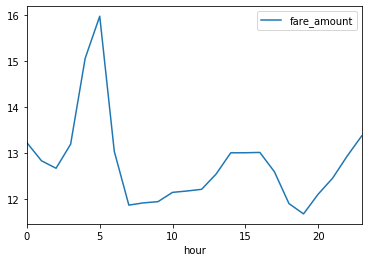

In [16]:
%matplotlib inline
taxi_df.groupby('hour').fare_amount.mean().to_pandas().sort_index().plot(legend=True)

In [17]:
X_train = taxi_df.query('day < 25')

# create a Y_train ddf with just the target variable
Y_train = X_train[['fare_amount']]

# drop the target variable from the training ddf
X_train = X_train[X_train.columns.difference(['fare_amount'])]

# Create a DMatrix
dtrain = xgb.DMatrix(X_train, Y_train)

In [18]:
%%time

# Train XGBoost
params = {
    'learning_rate'  : 0.3,
    'max_depth'      : 8,
    'objective'      : 'reg:squarederror',
    'subsample'      : 0.6,
    'gamma'          : 1,
    'silent'         : True,
    'verbose_eval'   : True,
    'tree_method'    :'gpu_hist'
}


trained_model = xgb.train(params, dtrain)

CPU times: user 4.39 s, sys: 2.07 s, total: 6.46 s
Wall time: 6.5 s


In [19]:
X_test = taxi_df.query('day >= 25')

# Create Y_test with just the fare amount
Y_test = X_test[['fare_amount']]

# Drop the fare amount from X_test
X_test = X_test[X_test.columns.difference(['fare_amount'])]

dtest = xgb.DMatrix(X_test, Y_test)

In [20]:
%%time

# generate predictions on the test set
Y_test['prediction'] = trained_model.predict(dtest)

CPU times: user 36.8 ms, sys: 21.2 ms, total: 58 ms
Wall time: 56.5 ms


In [21]:
Y_test['squared_error'] = (Y_test['prediction'] - Y_test['fare_amount'])**2

# inspect the results to make sure our calculation looks right
Y_test.head()

,fare_amount,prediction,squared_error
176,9.0,8.668865,0.109650
177,41.0,38.737236,5.120101
178,9.0,8.752189,0.061410
179,4.5,4.266047,0.054734
180,9.0,8.781436,0.047770


In [22]:
# compute the actual RMSE over the full test set
RMSE = Y_test.squared_error.mean()
math.sqrt(RMSE)

1.3442650608761757